In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn import preprocessing

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [3]:
n = 100
g = 1000
o = 10
k = 20
genesImpactingPhenotype = 50

In [87]:
def GenerateDataset(n=100, g=1000, o=10, k=20, genesImpactingPhenotype=50):
    X_cls, y_cls = make_classification(n_samples=g, n_features=n, n_informative=20, n_redundant=20,
                                       n_repeated=0, n_classes=k, n_clusters_per_class=5, weights=None, 
                                       flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, 
                                       shuffle=True, random_state=None)
    X_cls = X_cls.T
    binaryPathwayMatrix = np.zeros((g, k))
    binaryPathwayMatrix[np.arange(g), y_cls] = 1
    Y, geneCoeffs = GenerateRegressedPhenotype(X_cls, numPhenotypes=o, lam=genesImpactingPhenotype, binaryPathwayMatrix=None, coeffSigma=0.1)
    X = np.concatenate([Y, X_cls], axis=1)
    neighbors = GetNeighborDictionary(binaryPathwayMatrix)
    X_scaled = preprocessing.scale(X)    
    return X_scaled, binaryPathwayMatrix, geneCoeffs

def DatasetToDF(X_scaled, binaryPathwayMatrix, geneCoeffs):
    y_cls = np.where(binaryPathwayMatrix > 0)[1]
    
    df = pd.DataFrame(X_scaled.T)
    is_gene = np.ones(g + o)
    is_gene[0:o] = 0
    gene_group = np.append(np.full(o, np.nan), y_cls)
    gene_coeff = np.append(np.full(o, np.nan), geneCoeffs)
    df['is_gene'] = is_gene
    df['gene_group'] = gene_group
    df = pd.concat([df, pd.DataFrame(np.concatenate([np.eye(o), geneCoeffs]), columns=['coeff{}'.format(i) for i in range(o)])], axis=1)
    return df

def DFtoDataset(df):
    X_scaled = df[np.arange(n)].values.T
    y_cls = df['gene_group'].values[o:].astype(np.int32)
    binaryPathwayMatrix = np.zeros((g, k))
    binaryPathwayMatrix[np.arange(g), y_cls] = 1
    geneCoeffs = df[['coeff{}'.format(i) for i in range(o)]].values[o:, :]  

    return X_scaled, binaryPathwayMatrix, geneCoeffs

In [109]:
X_scaled, binaryPathwayMatrix, geneCoeffs = GenerateDataset(n=100, g=1000, o=10, k=20, genesImpactingPhenotype=50)
df = DatasetToDF(X_scaled, binaryPathwayMatrix, geneCoeffs)
X_scaled_rec, binaryPathwayMatrix_rec, geneCoeffs_rec = DFtoDataset(df)
assert np.all(X_scaled == X_scaled_rec)
assert np.all(binaryPathwayMatrix == binaryPathwayMatrix_rec)
assert np.all(geneCoeffs == geneCoeffs_rec)

In [110]:
print("Genes relevant to the first phenotype:")
print(np.where(geneCoeffs[:, 0] != 0)[0])

Genes relevant to the first phenotype:
[  0  19 193 209 234 241 448 469 483 492 503 600 609 610 663 667 678 685
 700 706 708 759 761 767 780 786 801 843 856 873 888 908 915 924 950]


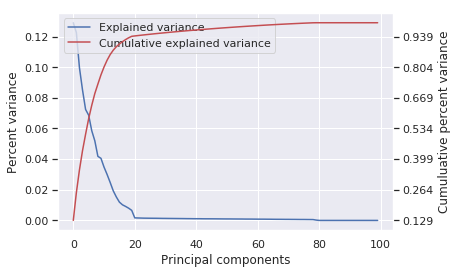

In [111]:
ScreePlot(X_scaled.T)

/homes/gws/psturm/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


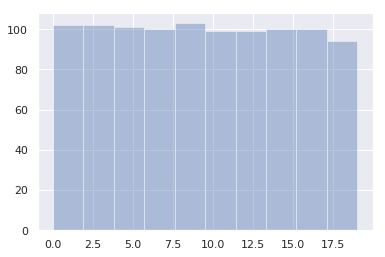

In [112]:
sns.distplot(y_cls, kde=False)

In [114]:
for i in range(100):
    X_scaled, binaryPathwayMatrix, geneCoeffs = GenerateDataset(n=100, g=1000, o=10, k=20, genesImpactingPhenotype=50)
    df = DatasetToDF(X_scaled, binaryPathwayMatrix, geneCoeffs)
    df.to_csv('/homes/gws/psturm/simulatedData/regressionData/df{}.csv'.format(i), index=False)